## Lending Club Hands On Session

### Dataset

- Loan data from 2007 up until 2015 including rejected applications and accepted applications.
- Of the 500k accepted applicants about 160k loans have either been completely paid off or defaulted.
- There are about 4million applicants in the rejected loans dataset.
- We are only going to pull about 42000 loan applicants for this particular demo.

#### Data Dictionary

To get an idea of all the different features available in the dataset:

![](https://s3-us-west-1.amazonaws.com/testing-amy/lending_club_demo_images/lc_datadict.png)

Since 2016, Lending Club has added new features to the each loan application. Also if you log into Lending Club securely you can download the FICO credit score associated with each loan app.

#### Possible Use Cases:
- Use Case 1 Predict the likelihood of a user defaulting based on the information supplied when applying for a loan.
- Use Case 2 Determine the interest rate Lending  Club would have offered the user based on the information supplied when applying for a loan.
- Use Case 3 Based on the subset of information available in both rejected and accepted loans, predict the likelihood Lending Club will approve your loan request.

## START H2O

To launch h2o locally from R, execute `h2o.init`. To use all available threads run with `nthreads = -1`. To see all available arguments and parameters for any h2o function run `?h2o.init` to access the R documentation. 

In [34]:
library(h2o)

In [7]:
?h2o.init

In [35]:
h2o.init(nthreads = -1)

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         47 minutes 11 seconds 
    H2O cluster version:        3.10.4.3 
    H2O cluster version age:    1 month and 15 days  
    H2O cluster name:           H2O_started_from_R_amy_vms812 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.10 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:                  R version 3.3.2 (2016-10-31) 



## Task 1: Import dataset.

If possible download from the s3 link and change the path to the dataset. Download Link: http://h2o-public-test-data.s3.amazonaws.com/bigdata/laptop/lending-club/LoanStats3a.csv. Then set the variable `small_test_path` to where your downloaded LoanStats file is.

For example: `small_test_path <- "/Users/amy/h2o-3/bigdata/laptop/lending-club/LoanStats3a.csv"`

Parse with user imposed schema which changes the column types of column: 'int_rate', 'revol_util', 'emp_length', 'verification_status' to String instead of Enum so we can modify the columns.

In [37]:
small_test_path <- "/Users/amy/h2o-3/bigdata/laptop/lending-club/LoanStats3a.csv"
col_types <- c('Numeric', 'Numeric', 'Numeric', 'Numeric', 'Numeric', 'Enum', 'String', 'Numeric', 
               'Enum', 'Enum', 'Enum', 'String', 'Enum', 'Numeric', 'String', 'Time', 'Enum', 'Enum', 
               'String', 'Enum', 'Enum', 'Enum', 'Enum', 'Enum', 'Numeric', 'Numeric', 'Time', 'Numeric', 
               'Enum', 'Enum', 'Numeric', 'Numeric', 'Numeric', 'String', 'Numeric', 'Enum', 'Numeric', 
               'Numeric', 'Numeric', 'Numeric', 'Numeric', 'Numeric', 'Numeric', 'Numeric', 'Numeric', 
               'Enum', 'Numeric', 'Enum', 'Time', 'Numeric', 'Enum', 'Numeric')
loanStats <- h2o.importFile(path = small_test_path, col.types = col_types)
summary(loanStats)

  |======================================================================| 100%


Warning message in summary.H2OFrame(loanStats):
“Approximated quantiles computed! If you are interested in exact quantiles, please pass the `exact_quantiles=TRUE` parameter.”

 id                member_id         loan_amnt       funded_amnt    
 Min.   :  54734   Min.   :  70473   Min.   :  500   Min.   :  500  
 1st Qu.: 497593   1st Qu.: 637598   1st Qu.: 5192   1st Qu.: 4985  
 Median : 643848   Median : 824152   Median : 9677   Median : 9574  
 Mean   : 664580   Mean   : 825703   Mean   :11090   Mean   :10822  
 3rd Qu.: 824878   3rd Qu.:1033093   3rd Qu.:14990   3rd Qu.:14990  
 Max.   :1077501   Max.   :1314167   Max.   :35000   Max.   :35000  
 NA's   :3         NA's   :3         NA's   :3       NA's   :3      
 funded_amnt_inv term              int_rate installment       grade    
 Min.   :    0    36 months:31534           Min.   :  15.67   B :12389 
 1st Qu.: 4935    60 months:11001           1st Qu.: 165.25   A :10183 
 Median : 8470   NA        :    3           Median : 277.44   C : 8740 
 Mean   :10140                              Mean   : 322.63   D : 6016 
 3rd Qu.:14000                              3rd Qu.: 427.67   E : 3394 
 Max.   :35000  

## Task 2: Look at the levels in the response column loan_status

Let's inspect our response column: "loan_status".

`as.h2o` - Downloads data.frame out to disk as a tmp file and then execute `h2o.uploadFile` to upload the file to H2O.

`as.data.frame` and `as.matrix` - Download an H2OFrame from H2O to disk and uses either `read.csv` or `fread` to import the data into R.

Create a frequency count table of all the different levels in the "loan_status" column using `h2o.table` on the H2OFrame and then bring it back into R to view the entire frame:
<p>
<details>
    <summary>Click Me to Reveal Answer</summary>
    <p><tt>as.data.frame(h2o.table(loanStats$loan_status))</tt>
    </p>
</details>

In [38]:
## Input answer
as.data.frame(h2o.table(loanStats$loan_status))

loan_status,Count
Charged Off,5435
Current,3351
Default,7
Does not meet the credit policy. Status:Charged Off,761
Does not meet the credit policy. Status:Current,53
Does not meet the credit policy. Status:Fully Paid,1933
Does not meet the credit policy. Status:In Grace Period,2
Fully Paid,30843
In Grace Period,60
Late (16-30 days),16


## Task 3:  Filter out all loans that are completed, aka subset data

You can run subset with the exact same syntax as you would on a R frame.

Note: "Current", "In Grace Period", "Late (16-30 days)", "Late (31-120 days)" are ongoing loans.
<p>
<details>
    <summary>Click Me to Reveal Answer</summary>
    <p><tt>loanStats <- loanStats[!(loanStats[,"loan_status"] %in% c("Current", "In Grace Period", "Late (16-30 days)", "Late (31-120 days)")), ]</tt>
    </p>
</details>

In [39]:
## Input answer
loanStats <- loanStats[!(loanStats[,"loan_status"] %in% c("Current", "In Grace Period", "Late (16-30 days)", "Late (31-120 days)")), ]


## Task 4: Bin the response variable to good/bad loans only, use your best judgment for what is a good/bad loan

Create new column called bad_loan which should be a binary variable
Hint: You can turn the bad_loan column into factor using as.factor
<p>
<details>
    <summary>Click Me to Reveal Answer</summary>
    <br><tt>loanStats[, "bad_loan"] <- loanStats[,"loan_status"] %in% c("Charged Off", "Default", "Does not meet the credit policy.  Status:Charged Off")
    </br> <br>
    loanStats[, "bad_loan"] <- as.factor(loanStats[,"bad_loan"])</tt>
    </br>
</details>


In [40]:
## Input answer
loanStats[, "bad_loan"] <- loanStats[,"loan_status"] %in% c("Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off")
loanStats[, "bad_loan"] <- as.factor(loanStats[,"bad_loan"])

## Task 5: String munging to clean string columns before converting to numeric

Hint: Columns that need munging includes "int_rate", "revol_util", "emp_length".

```
## Example for int_rate using h2o.strsplit, trim, as.numeric
loanStats[, "int_rate"] <- h2o.strsplit(loanStats[, "int_rate"], split = "%")
loanStats[, "int_rate"] <- h2o.trim(loanStats[, "int_rate"])
loanStats[, "int_rate"] <- as.numeric(loanStats[, "int_rate"])
```

<details>
    <summary>Click Me to Reveal Answer</summary>
    <br><tt>loanStats[, "revol_util"] <- h2o.strsplit(loanStats[, "revol_util"], split = "%")
    </br> <br>loanStats[, "revol_util"] <- h2o.trim(loanStats[, "revol_util"]) 
    </br> <br>loanStats[, "revol_util"] <- as.numeric(loanStats[, "revol_util"]) </tt>
    </br>
</details>


In [41]:
## Example for int_rate using h2o.strsplit, trim, as.numeric
loanStats[, "int_rate"] <- h2o.strsplit(loanStats[, "int_rate"], split = "%")
loanStats[, "int_rate"] <- h2o.trim(loanStats[, "int_rate"])
loanStats[, "int_rate"] <- as.numeric(loanStats[, "int_rate"])

## Input Answer
loanStats[, "revol_util"] <- h2o.strsplit(loanStats[, "revol_util"], split = "%") 
loanStats[, "revol_util"] <- h2o.trim(loanStats[, "revol_util"]) 
loanStats[, "revol_util"] <- as.numeric(loanStats[, "revol_util"])

## Now we're going to clean up emp_length.
## Use h2o.sub to remove " year" and " years", also translate n/a to ""
loanStats[, "emp_length"] <- h2o.sub(x = loanStats[, "emp_length"], pattern = "([ ]*+[a-zA-Z].*)|(n/a)", replacement = "")
## Use h2o.trim to remove any trailing spaces
loanStats[, "emp_length"] <- h2o.trim(loanStats[, "emp_length"])
## Use h2o.sub to convert < 1 to 0 years and do the same for 10 + to 10 
## Hint: Be mindful of spaces between characters
loanStats[, "emp_length"] <- h2o.sub(x = loanStats[, "emp_length"], pattern = "< 1", replacement = "0")
loanStats[, "emp_length"] <- h2o.sub(x = loanStats[, "emp_length"], pattern = "10\\\\+", replacement = "10")
loanStats[, "emp_length"] <- as.numeric(loanStats[, "emp_length"])

## Task 6: Create new feature called "credit_length_in_years"

I want to see what is the longest credit line the applicant has held. Use date/time functions supported by h2o to find out credit length. Keep in mind that the column was already imported as a Date column but you can also import it as a String and convert the column by using `as.Date`.
<p>
Hint: Use the columns "earliest_cr_line" and "issue_d" which are both date columns.

`h2o.year`, `h2o.month`, `h2o.dayOfWeek`, `h2o.hour` are all h2o functions that allow you to decipher time columns and transform them into human readable int.


<p>

<details>
    <summary>Click Me to Reveal Answer</summary>
    <br><tt>loanStats[, "credit_length_in_years"] <- h2o.year(loanStats[,"issue_d"]) - h2o.year(loanStats[,"earliest_cr_line"])
 </tt>
    </br>
</details>

In [42]:
## Input Answer
loanStats[, "credit_length_in_years"] <- h2o.year(loanStats[,"issue_d"]) - h2o.year(loanStats[,"earliest_cr_line"])

## Task 7: Use h2o.sub to create two levels for column "verification_status" i.e. "verified" and "not verified"

Hint: Use h2o.table to examine levels within "verification_status"

<p>

<details>
    <summary>Click Me to Reveal Answer</summary>
    <br><tt>loanStats[, "verification_status"] <- h2o.sub(x = loanStats[, "verification_status"], pattern = "VERIFIED - income source", replacement = "verified")
    </br> <br>loanStats[, "verification_status"] <- h2o.sub(x = loanStats[, "verification_status"], pattern = "VERIFIED - income", replacement = "verified")
    </br> <br>loanStats[, "verification_status"] <- as.factor(loanStats[, "verification_status"])
    </br> <br>h2o.table(loanStats[, "verification_status"])</tt>
    </br>
</details>


In [43]:
## Input Answer
loanStats[, "verification_status"] <- h2o.sub(x = loanStats[, "verification_status"], pattern = "VERIFIED - income source", replacement = "verified")
loanStats[, "verification_status"] <- h2o.sub(x = loanStats[, "verification_status"], pattern = "VERIFIED - income", replacement = "verified")
loanStats[, "verification_status"] <- as.factor(loanStats[, "verification_status"])
h2o.table(loanStats[, "verification_status"])

  verification_status Count
1        not verified 17965
2            verified 21069

[2 rows x 2 columns] 

## Task 8: Define your response and predictor variables

<p>

<details>
    <summary>Click Me to Reveal Example Code</summary>
    <br><tt>myY <- "bad_loan"
    </br> <br>myX <-  c("loan_amnt", "term", "home_ownership", "annual_inc", "verification_status", "purpose",
          "addr_state", "dti", "delinq_2yrs", "open_acc", "pub_rec", "revol_bal", "total_acc",
          "emp_length", "credit_length_in_years", "inq_last_6mths", "revol_util")</tt>
    </br>
</details>


In [44]:
## Fix myX!
myY <- "bad_loan"
myX <-  c("loan_amnt", "term", "home_ownership", "annual_inc", "verification_status", "purpose",
          "addr_state", "dti", "delinq_2yrs", "open_acc", "pub_rec", "revol_bal", "total_acc",
          "emp_length", "credit_length_in_years", "inq_last_6mths", "revol_util")

## Task 9: Do a test-train split (80-20)

Use `h2o.splitFrame` to create random splits. It will return two objects both pointers to the new frame. Assign the first object to be the training set, and the second is the validation set.

Note: Use h2o.splitFrame ONLY once!
Note: Use h2o.table to see if the ratio of the response class is maintained

<p>

<details>
    <summary>Click Me to Reveal Example Code</summary>
    <br><tt>split <- h2o.splitFrame(loanStats, ratios = 0.8)
    </br> <br>train <- split[[1]]</br> <br>valid <- split[[2]]</tt>
    </br>
</details>


In [46]:
## Input Answer
split <- h2o.splitFrame(loanStats, ratios = 0.8)
train <- split[[1]]
valid <- split[[2]]

In [47]:
## Use h2o.table to see if the ratio of the response class is maintained
h2o.table(loanStats[,myY])
h2o.table(train[,myY])
h2o.table(valid[,myY])

  bad_loan Count
1        0 33595
2        1  5442

[2 rows x 2 columns] 

  bad_loan Count
1        0 26913
2        1  4368

[2 rows x 2 columns] 

  bad_loan Count
1        0  6682
2        1  1074

[2 rows x 2 columns] 

## Task 10: Build model predicting good/bad loan 

Use any of the classification methods available including GLM, GBM, Random Forest, and Deep Learning. Just reply to specify your x, y, training_frame, and validation frame. In the case of GLM you will need to specify the family of distribution as well which in our case is "binomial".

<p>

<details>
    <summary>Click Me to Reveal Example Code</summary>
    <br><tt>glm_model <- h2o.glm(x = myX, y = myY, training_frame = train, validation_frame = valid, family = "binomial", model_id = "GLM_BadLoan")
    </br> <br>gbm_model <- h2o.gbm(x = myX, y = myY, training_frame = train, validation_frame = valid,
                     learn_rate = 0.05, score_each_iteration = T, ntrees = 50, model_id = "GBM_BadLoan")
</tt>
    </br>
</details>


In [48]:
## Input Answer
glm_model <- h2o.glm(x = myX, y = myY, training_frame = train, validation_frame = valid,
                     family = "binomial", model_id = "GLM_BadLoan")
gbm_model <- h2o.gbm(x = myX, y = myY, training_frame = train, validation_frame = valid,
                     learn_rate = 0.05, score_each_iteration = T, ntrees = 50, model_id = "GBM_BadLoan")

  |======================================================================| 100%
  |======================================================================| 100%


## Task 11: Plot the scoring history to make sure you're not overfitting

Hint: Use plot function on the model object

<p>

<details>
    <summary>Click Me to Reveal Example Code</summary>
    <br><tt>plot(gbm_model)
    </tt>
    </br>
</details>


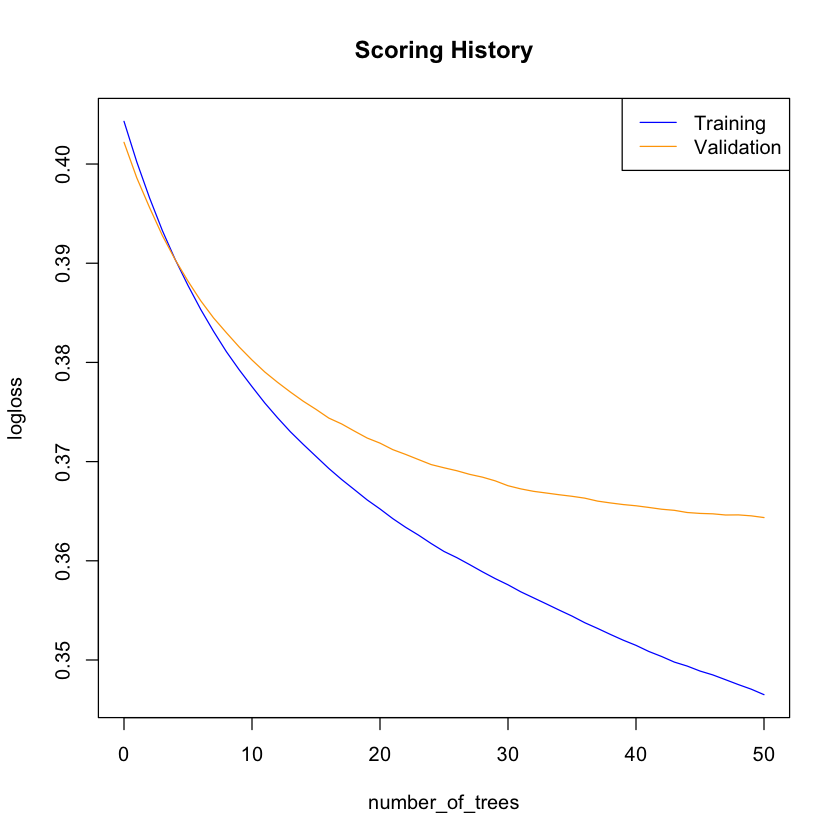

In [50]:
## Input Answer
plot(gbm_model)

## Task 12: Plot the ROC curve for the binomial models and get auc using h2o.auc

Use `h2o.performance` and `plot` to grab the modelmetrics and then plotting the model metrics:

<p>

<details>
    <summary>Click Me to Reveal Example Code</summary>
    <br><tt>perf <- h2o.performance(model = gbm_model)
    </br> <br>plot(perf, train = T)
    </br> <br>plot(perf, train = F)</tt>
    </br>
</details>


Warning message in plot.window(...):
“"train" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"train" is not a graphical parameter”Warning message in axis(side = side, at = at, labels = labels, ...):
“"train" is not a graphical parameter”Warning message in axis(side = side, at = at, labels = labels, ...):
“"train" is not a graphical parameter”Warning message in box(...):
“"train" is not a graphical parameter”Warning message in title(...):
“"train" is not a graphical parameter”Warning message in plot.window(...):
“"valid" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"valid" is not a graphical parameter”Warning message in axis(side = side, at = at, labels = labels, ...):
“"valid" is not a graphical parameter”Warning message in axis(side = side, at = at, labels = labels, ...):
“"valid" is not a graphical parameter”Warning message in box(...):
“"valid" is not a graphical parameter”Warning message in title(...):
“"valid" is not a graphica

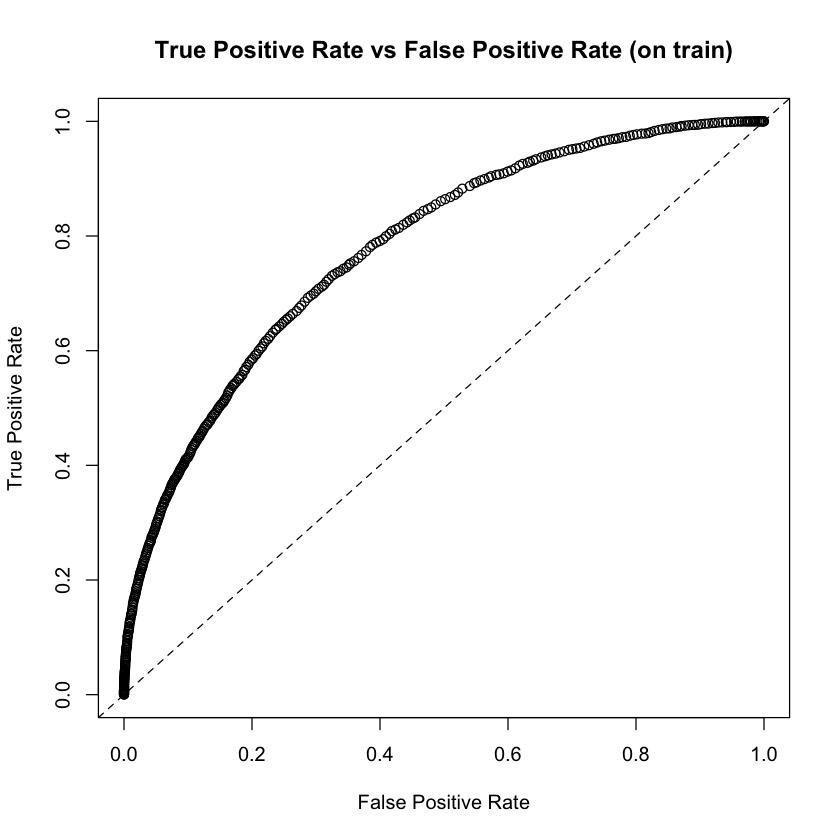

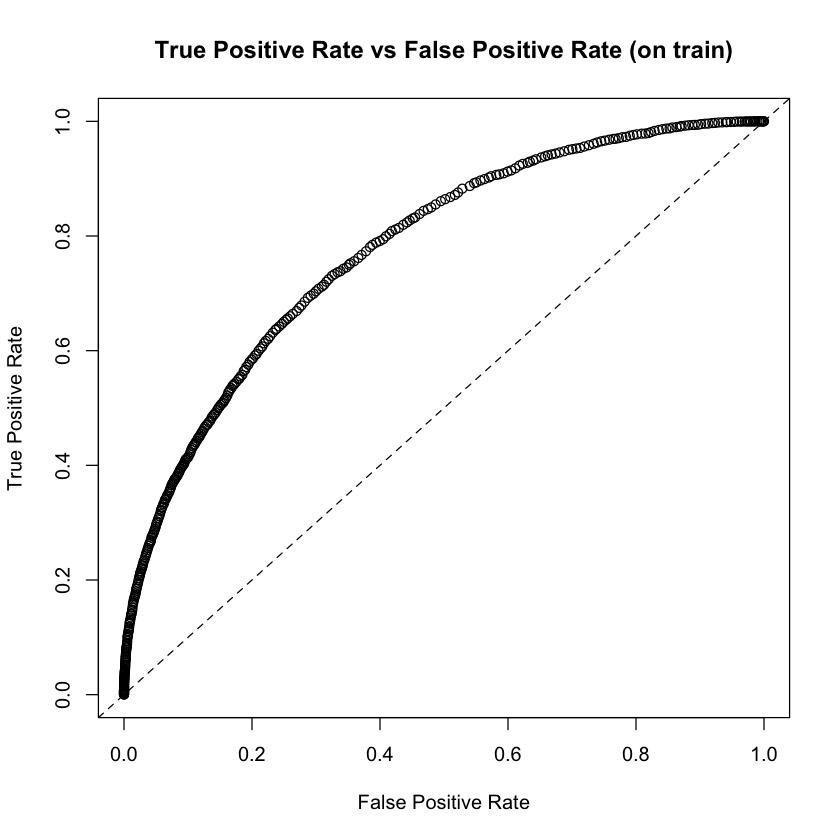

In [51]:
## Input Answer
perf <- h2o.performance(model = gbm_model)
plot(perf, train = T)
plot(perf, valid = T)

In [52]:
## Grab the AUC value for all the models. 
h2o.auc(gbm_model, train = T)
h2o.auc(gbm_model, valid = T)

h2o.auc(glm_model, train = T)
h2o.auc(glm_model, valid = T)

[1] 0.778469

[1] 0.7177208

[1] 0.7077734

[1] 0.7020895

## Task 8: Task 13: Check the variable importance


Use `h2o.varimp_plot` for non-GLM model and use `h2o.std_coef_plot` for GLM models. Also, limit number of features in order to get a better plot for GLM models.
<p>

<details>
    <summary>Click Me to Reveal Example Code</summary>
    <br><tt>varimp_chart = h2o.varimp(gbm_model)
    </br> <br>h2o.varimp_plot(gbm_model)</tt>
    </br>
</details>


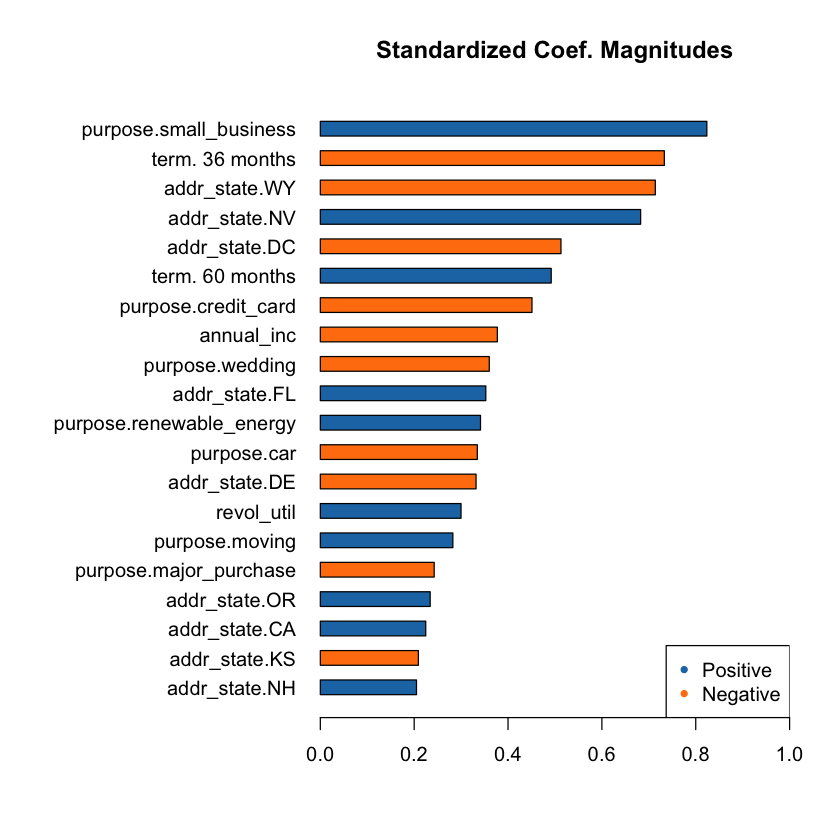

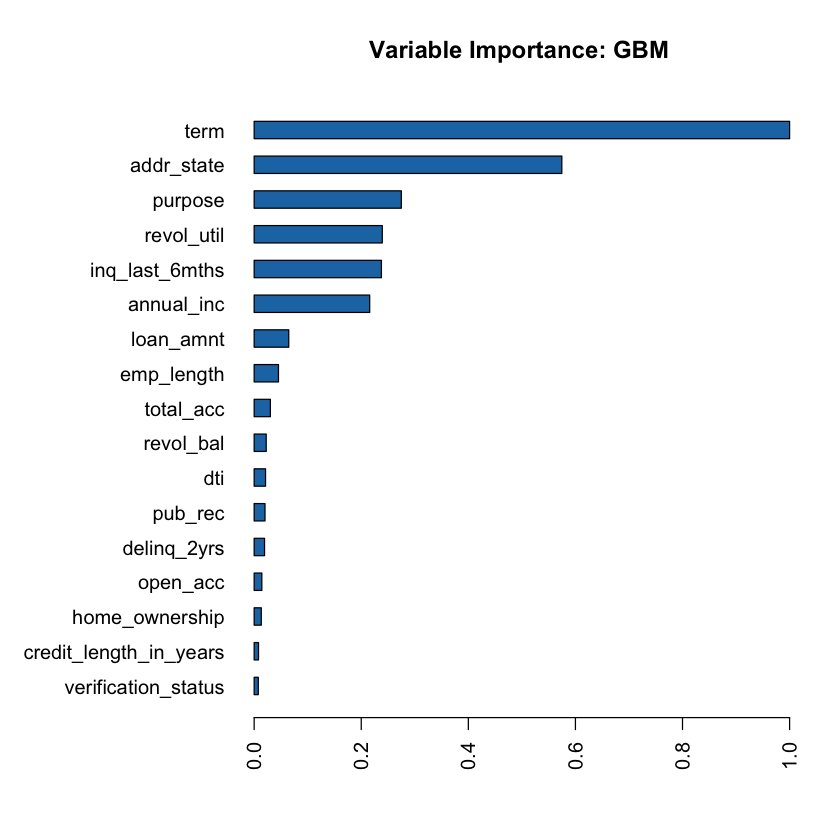

In [53]:
## Standardized Mag. Coef for GLM model
std_coef_chart = glm_model@model$standardized_coefficient_magnitudes
std_coef_plot = h2o.std_coef_plot(glm_model, num_of_features = 20)

## Input Answer for GBM model
varimp_chart = h2o.varimp(gbm_model)
varimp_plot = h2o.varimp_plot(gbm_model)

## Task 14: Score the entire data set using the model

Use `h2o.predict` and supply the model you want to predict with and the dataset you want to predict on.

<p>

<details>
    <summary>Click Me to Reveal Example Code</summary>
    <br><tt>pred <- h2o.predict(gbm_model, loanStats)</tt>
    </br>
</details>


In [54]:
## Input Answer
pred <- h2o.predict(gbm_model, loanStats)

  |======================================================================| 100%


## Extra: Calculate the money gain/loss if model is implemented

In [55]:
## Calculate the total amount of money earned or lost per loan
loanStats$earned <- loanStats$total_pymnt - loanStats$loan_amnt

## Calculate how much money will be lost to false negative, vs how much will be saved due to true positives
loanStats$pred <- pred[,1]
net <- as.data.frame(h2o.group_by(data = loanStats, by = c("bad_loan", "pred"), gb.control = list(na.methods = "ignore"), sum("earned")))
n1  <- net[ net$bad_loan == 0 & net$pred == 0, 3]
n2  <- net[ net$bad_loan == 0 & net$pred == 1, 3]
n3  <- net[ net$bad_loan == 1 & net$pred == 1, 3]
n4  <- net[ net$bad_loan == 1 & net$pred == 0, 3]


## Function defined to pretty print numerics as dollars
printMoney <- function(x){
  x <- round(abs(x),2)
  format(x, digits=10, nsmall=2, decimal.mark=".", big.mark=",")
}

## Calculate the amount of earned
print(paste0("Total amount of profit still earned using the model : $", printMoney(n1) , ""))
print(paste0("Total amount of profit forfeitted using the model : $", printMoney(n2) , ""))
print(paste0("Total amount of loss that could have been prevented : $", printMoney(n3) , ""))
print(paste0("Total amount of loss that still would've accrued : $", printMoney(n4) , ""))
## Calculate Net
print(paste0("Total profit by implementing model : $", printMoney( n1 - n2 + n3 - n4)))


[1] "Total amount of profit still earned using the model : $34,874,283.19"
[1] "Total amount of profit forfeitted using the model : $15,040,615.38"
[1] "Total amount of loss that could have been prevented : $19,766,302.39"
[1] "Total amount of loss that still would've accrued : $11,284,999.37"
[1] "Total profit by implementing model : $11,352,364.80"
